In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os.path
import tensorflow as tf
import tensorflow_text as text
import heapq
from collections import defaultdict
import nltk
from nltk.corpus import stopwords
import string
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

data_path = '../local_data/'

# Data Origin: https://huggingface.co/datasets/OpenCo7/UpVoteWeb

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Oyka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
sample_df = pd.read_parquet(data_path + 'full_cleaned.parquet').sample(n=1000000, random_state=42)

In [4]:
print(sample_df.describe())
print(sample_df.head())


                score     token_count
count  1000000.000000  1000000.000000
mean        10.744958       41.717826
std         81.827338       73.353183
min       -752.000000        0.000000
25%          1.000000       10.000000
50%          2.000000       21.000000
75%          6.000000       47.000000
max      22656.000000    15000.000000
              id   parent_id  post_id  \
1053884  kft93ay  t1_kfpsce7  18v92qz   
2007578  kgaouq0  t1_kg9bvog  18vw0iz   
348753   kg8dmbg  t3_18xmvnu  18xmvnu   
1872837  kgac2qs  t3_18yen66  18yen66   
1172406  kg9g21v  t3_18xwc7c  18xwc7c   

                                                      text       subreddit  \
1053884                                      r/emojipolice     indianmemer   
2007578  she remains an admirer of the man who save her...  shitpostemblem   
348753   so im confused. my stores had these since spri...       starbucks   
1872837  porque quem age igual a cristo é crucificado. ...          brasil   
1172406  almost every

In [5]:
print(sample_df['subreddit'].value_counts().head(10))

top_subreddits = sample_df['subreddit'].value_counts().head(10).index.tolist()


# Filter out the top 10 subreddits
sample_df = sample_df[sample_df['subreddit'].isin(top_subreddits)]

# One hot encode the top 10 subreddits
for subreddit in top_subreddits:
    sample_df[subreddit] = np.where(sample_df['subreddit'] == subreddit, 1, 0)

print(sample_df.describe())

subreddit
CFB                  16184
AskReddit            10458
nfl                   7044
AITAH                 5029
nba                   4381
AmItheAsshole         3885
SquaredCircle         3779
politics              3647
NoStupidQuestions     3284
movies                3139
Name: count, dtype: int64
              score   token_count           CFB     AskReddit           nfl  \
count  60830.000000  60830.000000  60830.000000  60830.000000  60830.000000   
mean      18.666974     36.108647      0.266053      0.171922      0.115798   
std      179.509335     55.686744      0.441896      0.377316      0.319985   
min     -396.000000      0.000000      0.000000      0.000000      0.000000   
25%        1.000000      9.000000      0.000000      0.000000      0.000000   
50%        2.000000     19.000000      0.000000      0.000000      0.000000   
75%        7.000000     41.000000      1.000000      0.000000      0.000000   
max    22656.000000   3220.000000      1.000000      1.000000 

In [6]:
sample_df['tokenized'] = sample_df['text'].apply(lambda x: [word for word in nltk.word_tokenize(x) if word not in stop_words and word not in string.punctuation])



In [7]:
print(sample_df.head())

              id   parent_id  post_id  \
823567   kfw55uc  t3_18w6kt1  18w6kt1   
1603658  kfx3utn  t1_kfx2yow  18w6kt1   
855291   kg2jn7l  t3_18x50dx  18x50dx   
1583343  kfx4vnh  t3_18wd5xz  18wd5xz   
2076438  kfy4dp8  t1_kfxeep9  18vwbrd   

                                                      text          subreddit  \
823567   absolute dogshit game so far, these are playof...                CFB   
1603658  the snap went into the dirt again. it was over...                CFB   
855291   normally, i would say yta based on just the ti...              AITAH   
1583343  really proud of our players.  so much improvem...                CFB   
2076438  i have often thought of dying while hearing th...  NoStupidQuestions   

         score  token_count  CFB  AskReddit  nfl  AITAH  nba  AmItheAsshole  \
823567       2           13    1          0    0      0    0              0   
1603658      1           23    1          0    0      0    0              0   
855291       1           58  

In [8]:
word_list = []

for row in sample_df['tokenized']:
    word_list.extend(row)

num_words = 6000

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(word_list)
tokenized_train = tokenizer.texts_to_sequences(sample_df['tokenized'])

# Neural Network

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.layers import Dropout


In [10]:
X = pad_sequences(tokenized_train, maxlen=500)
y = sample_df[top_subreddits]

In [11]:
print(y.sum())

CFB                  16184
AskReddit            10458
nfl                   7044
AITAH                 5029
nba                   4381
AmItheAsshole         3885
SquaredCircle         3779
politics              3647
NoStupidQuestions     3284
movies                3139
dtype: int64


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [13]:
print(X_train[0])
print(y_train.head())

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [14]:
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=64, input_length=500))
model.add(LSTM(64))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 64)           384000    
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 421,834
Trainable params: 421,834
Non-trainable params: 0
_________________________________________________________________


In [15]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=0,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
)

In [16]:
results = model.fit(X_train, y_train, epochs=5, batch_size=128, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/5
381/381 [==============================] - 269s 701ms/step - loss: 1.7507 - accuracy: 0.3802 - val_loss: 1.5399 - val_accuracy: 0.4366
Epoch 2/5
381/381 [==============================] - 272s 715ms/step - loss: 1.3291 - accuracy: 0.5266 - val_loss: 1.3124 - val_accuracy: 0.5473


In [17]:
model.save(data_path + 'lstm_classify.h5')

In [26]:
model = tf.keras.models.load_model(data_path + 'lstm_classify.h5')

In [18]:
yhat_train = model.predict(X_train)
yhat_test = model.predict(X_test)

381/381 [==============================] - 14s 37ms/step


In [19]:
print(yhat_test[0:5])
print(y_test[0:5])

[[6.31391827e-04 7.01526463e-01 1.41644618e-03 7.87199289e-03
  4.21906705e-04 4.40974254e-03 4.03758313e-04 1.50569491e-02
  2.56343842e-01 1.19175473e-02]
 [8.39003742e-01 1.15355302e-03 1.22811787e-01 2.00895069e-04
  3.52842025e-02 2.32254806e-05 9.43019462e-04 3.45808774e-04
  1.01994665e-04 1.31739260e-04]
 [1.24422118e-01 6.11335300e-02 4.58141565e-01 2.43921336e-02
  1.95283785e-01 5.54829417e-03 2.59766895e-02 7.28035495e-02
  1.94739737e-02 1.28244441e-02]
 [2.63797015e-01 2.58865118e-01 7.83013254e-02 3.67774665e-02
  8.60224888e-02 2.56662201e-02 7.28388131e-02 4.94300760e-02
  5.73302247e-02 7.09712207e-02]
 [6.98377863e-02 1.47428215e-02 1.83528438e-01 2.83982535e-03
  6.63699090e-01 1.02706789e-03 4.29190062e-02 1.21893790e-02
  4.58129030e-03 4.63526230e-03]]
         CFB  AskReddit  nfl  AITAH  nba  AmItheAsshole  SquaredCircle  \
1423996    0          1    0      0    0              0              0   
582982     1          0    0      0    0              0           

In [20]:
print(results.history)

{'loss': [1.7507015466690063, 1.3291178941726685], 'accuracy': [0.3802194595336914, 0.5266110301017761], 'val_loss': [1.5399037599563599, 1.3123528957366943], 'val_accuracy': [0.436626672744751, 0.5473450422286987]}


In [21]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

yhat_test_index = np.argmax(yhat_test, axis=1)
y_test_index = np.argmax(y_test, axis=1)

print(classification_report(yhat_test_index, y_test_index, target_names=top_subreddits))

                   precision    recall  f1-score   support

              CFB       0.77      0.63      0.69      3941
        AskReddit       0.66      0.41      0.50      3368
              nfl       0.54      0.62      0.58      1246
            AITAH       0.26      0.42      0.32       603
              nba       0.44      0.64      0.52       576
    AmItheAsshole       0.52      0.49      0.50       855
    SquaredCircle       0.55      0.68      0.61       628
         politics       0.46      0.61      0.52       545
NoStupidQuestions       0.04      0.25      0.06        92
           movies       0.32      0.69      0.44       312

         accuracy                           0.55     12166
        macro avg       0.46      0.54      0.48     12166
     weighted avg       0.61      0.55      0.56     12166



<Axes: >

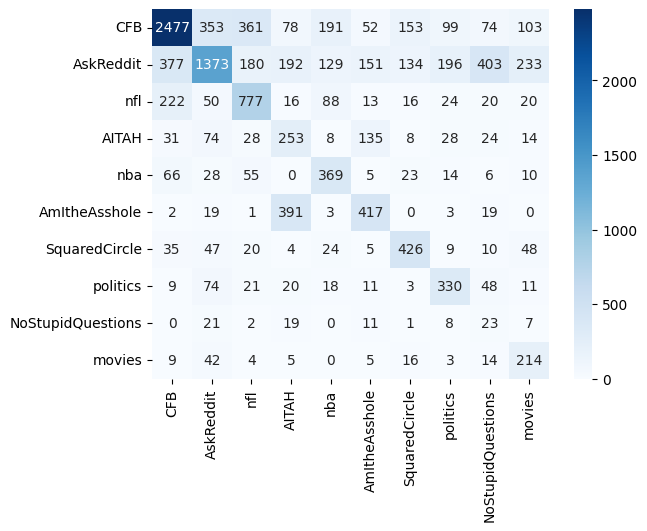

In [22]:
conf_matrix = confusion_matrix(yhat_test_index, y_test_index)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=top_subreddits, yticklabels=top_subreddits)